## 60frame 당 4~9회

In [33]:
import datetime
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from scipy.signal import argrelextrema

CONFIDENCE_THRESHOLD = 0.4
GREEN = (0, 255, 0)
WHITE = (255, 255, 255)
RED = (0, 0, 255)
YELLOW = (0, 255, 255)

# 클래스 정보 입력
with open('/Users/kimhyeonjeong/Documents/2024-2/OD/code/model/yolo_class.txt', 'r') as coco128:
    class_list = coco128.read().split('\n')

# YOLO 모델과 DeepSort 초기화
model = YOLO('/Users/kimhyeonjeong/Documents/2024-2/OD/code/model/best.pt')
tracker = DeepSort(max_age=20)

# 이미지 폴더 설정
image_folder_path = '/Users/kimhyeonjeong/Documents/2024-2/OD/code/test_data/test4/test4-10'  # 이미지 폴더 경로
file_names = os.listdir(image_folder_path)
image_files = [f for f in file_names if f.endswith(('.jpg', '.png'))]
image_files.sort()

# 트래킹 ID 및 라이트 RGB 기록을 저장할 딕셔너리 초기화
class_track_ids = {}
light_rgb_history = defaultdict(list)

# 비디오 저장 설정
output_video_path = '/Users/kimhyeonjeong/Documents/2024-2/OD/code/output/test4-10_output.mp4'
frame_width, frame_height = cv2.imread(os.path.join(image_folder_path, image_files[0])).shape[1], cv2.imread(os.path.join(image_folder_path, image_files[0])).shape[0]
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (frame_width, frame_height))

def get_extrema_diff_threshold(r_value):
    if r_value <= 125:
        return 20
    elif 125 < r_value <= 195:
        return 40
    else:
        return 60

# 주기 분석 함수 정의
def analyze_cycle_fft(r_values):
    fft_values = np.fft.fft(r_values)
    frequencies = np.fft.fftfreq(len(r_values))
    return frequencies, np.abs(fft_values)

# 이동 평균 계산 함수 정의
def calculate_shift_mean(r_values, window_size=1):
    if len(r_values) < window_size:
        return r_values  # 데이터 길이가 윈도우 크기보다 작으면 그대로 반환
    return np.convolve(r_values, np.ones(window_size) / window_size, mode='valid')

def analyze_cycle_extrema(r_values, extrema_diff_threshold, window_size=5):
    # 이동 평균 적용
    r_shift_mean_values = calculate_shift_mean(r_values, window_size)

    # 최소 61프레임 이상의 데이터가 필요
    if len(r_shift_mean_values) < 61:
        return False, 0

    max_valid_extrema_count = 0

    # 1프레임부터 61프레임, 2프레임부터 62프레임 등 61프레임 구간씩 이동하면서 피크 개수 계산
    for start in range(len(r_shift_mean_values) - 60):
        segment = r_shift_mean_values[start:start + 61]
        maxima = argrelextrema(np.array(segment), np.greater)[0]
        minima = argrelextrema(np.array(segment), np.less)[0]
        extrema = np.sort(np.concatenate((maxima, minima)))

        # 유효한 피크 판단: 극댓값과 극솟값의 차이가 일정 기준을 초과하는 경우만 피크로 간주
        valid_extrema = []
        for i in range(1, len(extrema)):
            diff = abs(segment[extrema[i]] - segment[extrema[i - 1]])
            if diff > extrema_diff_threshold:
                valid_extrema.append(extrema[i - 1])
                valid_extrema.append(extrema[i])

        valid_extrema = np.unique(valid_extrema)  # 중복 제거
        max_valid_extrema_count = max(max_valid_extrema_count, len(valid_extrema))

    # 61프레임 구간 중에서 피크 개수가 5~9개 사이인 경우가 있는지 확인
    has_valid_extrema = 4 <= max_valid_extrema_count <= 9
    return has_valid_extrema, max_valid_extrema_count

# 이미지 순차 처리
frame_count = 0
for image_file in image_files:
    image_path = os.path.join(image_folder_path, image_file)
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Warning: Could not load image {image_file}")
        continue

    # 프레임 처리 시작 시간
    start = datetime.datetime.now()

    # YOLO 모델을 사용하여 객체 감지 수행
    detection = model.predict(source=[frame], save=False)[0]
    results = []

    for data in detection.boxes.data.tolist():  # data : [xmin, ymin, xmax, ymax, confidence_score, class_id]
        confidence = float(data[4])
        if confidence < CONFIDENCE_THRESHOLD:
            continue

        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        width = xmax - xmin
        height = ymax - ymin
        label = int(data[5])
        class_name = class_list[label]

        # 클래스별 트래킹 ID 관리
        if class_name not in class_track_ids:
            class_track_ids[class_name] = {}

        bbox = (xmin, ymin, width, height)
        results.append([bbox, confidence, label])

    # DeepSort를 사용하여 트래킹 업데이트
    tracks = tracker.update_tracks(results, frame=frame)

    # 자동차 및 라이트 바운딩 박스 추출
    car_boxes = []
    light_boxes = []
    light_ids_rgb = []
    lights_on = []
    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        ltrb = track.to_ltrb()
        label = track.det_class
        class_name = class_list[label]

        # 트래킹 ID 할당
        if track_id not in class_track_ids[class_name]:
            class_track_ids[class_name][track_id] = f"{class_name}-{len(class_track_ids[class_name]) + 1}"

        assigned_id = class_track_ids[class_name][track_id]

        xmin, ymin, xmax, ymax = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])
        label_text = f"{assigned_id}"

        if class_name == "car":
            # 'car' 클래스에 대해서는 바운딩 박스를 GREEN으로 설정하고 주기성 분석 생략
            car_boxes.append((xmin, ymin, xmax, ymax))
            box_color = GREEN
        elif class_name == "light":
            # 'light' 클래스에 대해서만 주기성 및 피크 계산 수행
            light_boxes.append((xmin, ymin, xmax, ymax))
            box_color = WHITE  # 기본 색상은 WHITE
            
            # 라이트 바운딩 박스에서 RGB 값 추출 및 트래킹이 시작된 경우만 기록
            if track.is_confirmed() and track.time_since_update == 0:
                light_region = frame[ymin:ymax, xmin:xmax]
                avg_color = cv2.mean(light_region)[:3]  # BGR을 RGB로 변환
                light_rgb = (int(avg_color[2]), int(avg_color[1]), int(avg_color[0]))
                light_ids_rgb.append((assigned_id, light_rgb))

                # R 값 기록
                if not light_rgb_history[assigned_id]:
                    light_rgb_history[assigned_id] = [None] * frame_count
                light_rgb_history[assigned_id].append(light_rgb[0])  # R 값만 저장

            # 피크 수를 저장하는 딕셔너리 초기화
            last_num_extrema_dict = defaultdict(lambda: 0)

            # R 값 주기 분석 및 EXTREMA_DIFF_THRESHOLD 설정
            r_values = [r for r in light_rgb_history[assigned_id] if r is not None]
            if len(r_values) > 10:  # 충분한 데이터가 쌓였을 때 분석
                extrema_diff_threshold = get_extrema_diff_threshold(r_values[-1])
                
                frequencies, fft_magnitudes = analyze_cycle_fft(r_values)
                has_valid_extrema, num_extrema = analyze_cycle_extrema(r_values, extrema_diff_threshold=extrema_diff_threshold)
                print(f"Track ID: {assigned_id}, Number of Valid Extrema: {num_extrema}, Has Valid Extrema (4-7): {has_valid_extrema}")

                # 마지막으로 계산한 피크 수 저장
                last_num_extrema_dict[assigned_id] = num_extrema

                # 유효한 피크가 있는 경우 YELLOW로 색상 설정
                if has_valid_extrema:
                    box_color = YELLOW

            # 바운딩 박스 아래에 마지막으로 계산한 피크 수 시각화
            last_num_extrema = last_num_extrema_dict[assigned_id]
            cv2.putText(frame, f'Peaks: {last_num_extrema}', (xmin, ymax + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, 2)

        # 바운딩 박스 및 라벨 그리기
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), box_color, 2)
        cv2.putText(frame, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, 2)

    # FPS 계산 및 표시
    end = datetime.datetime.now()
    total = (end - start).total_seconds()
    fps = f'FPS: {1 / total:.2f}'
    cv2.putText(frame, f'FPS: {1 / total:.2f} (Time: {frame_count / 30:.2f}s)', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # 프레임 수 표시
    cv2.putText(frame, f'Frame: {frame_count} (Time: {frame_count / 30:.2f}s)', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    # 결과 프레임 저장
    out.write(frame)

    # 결과 프레임 표시
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) == ord('q'):
        break

    frame_count += 1

# 비디오 저장 종료
out.release()
cv2.destroyAllWindows()



0: 384x640 2 Cars, 166.5ms
Speed: 1.5ms preprocess, 166.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Cars, 158.9ms
Speed: 1.3ms preprocess, 158.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Cars, 146.4ms
Speed: 1.3ms preprocess, 146.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Cars, 168.9ms
Speed: 1.3ms preprocess, 168.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Cars, 1 Light, 169.4ms
Speed: 1.5ms preprocess, 169.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Cars, 1 Light, 177.5ms
Speed: 1.2ms preprocess, 177.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Cars, 1 Light, 170.9ms
Speed: 1.2ms preprocess, 170.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Cars, 174.8ms
Speed: 1.3ms preprocess, 174.8ms inference, 0.3ms postprocess p

KeyboardInterrupt: 

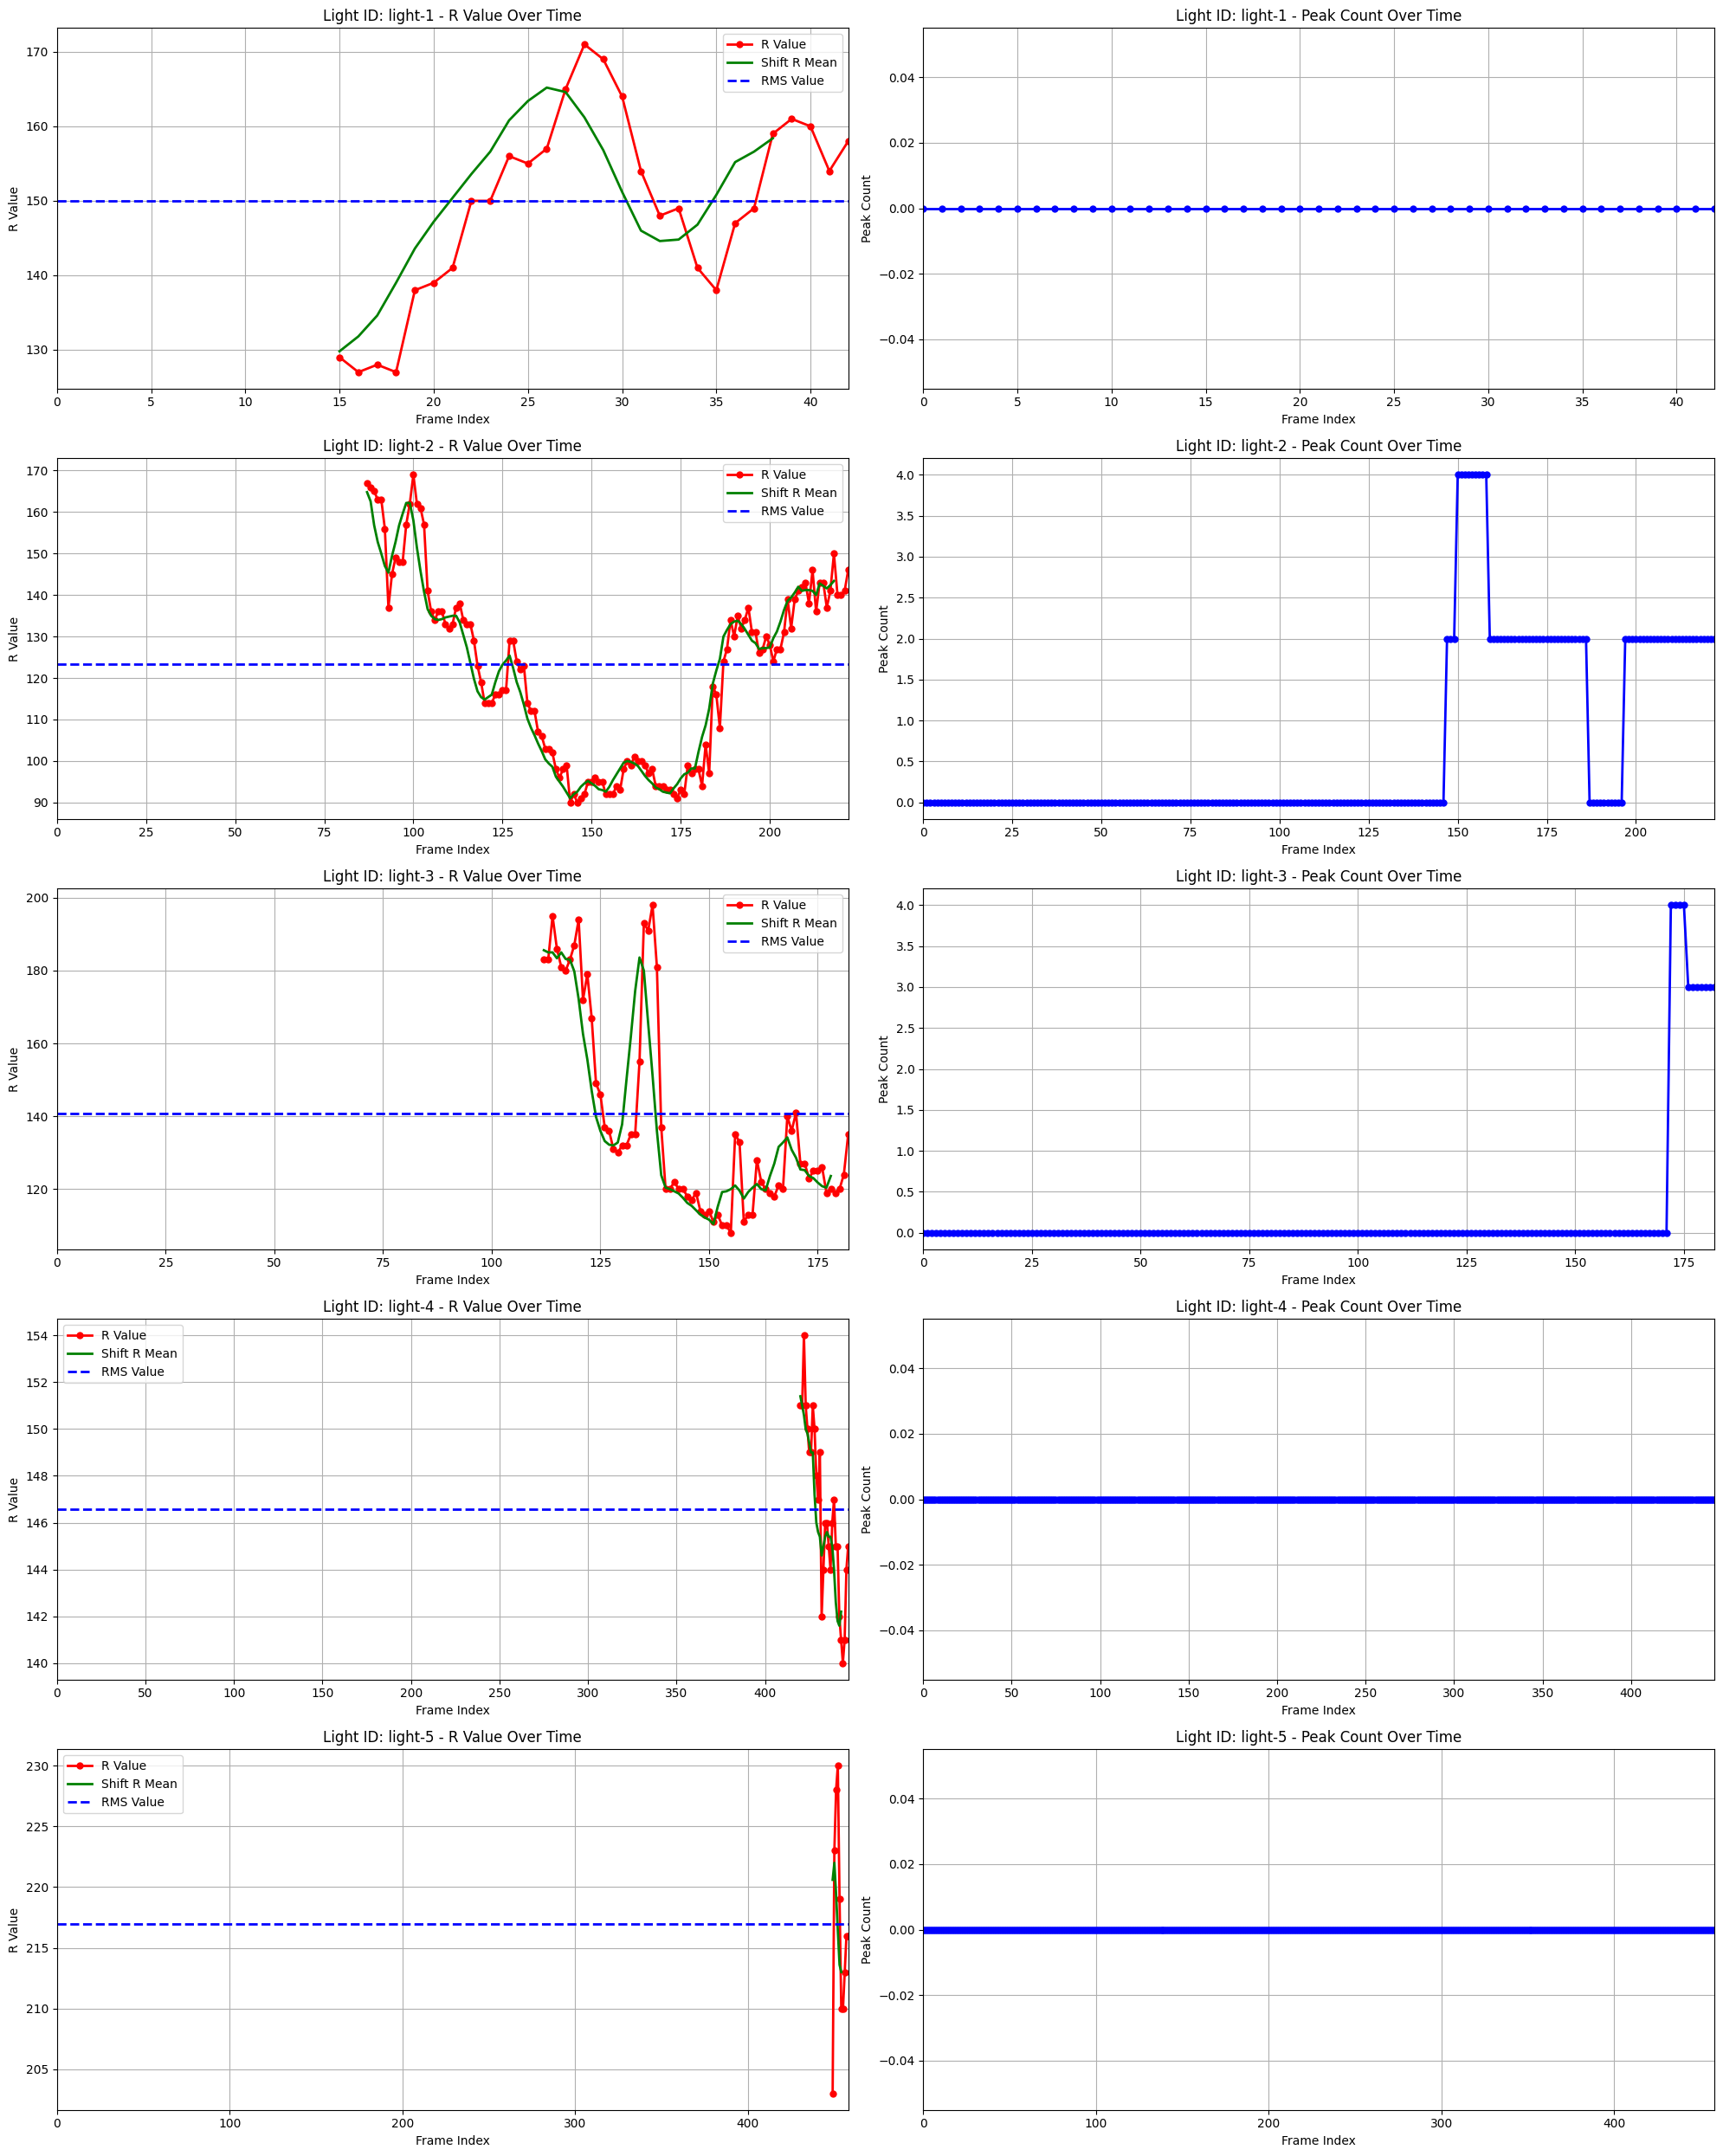

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

EXTREMA_DIFF_THRESHOLD = 20  # 극댓값과 극솟값의 차이를 피크로 간주할 최소 값

# 이동 평균 계산 함수 정의
def calculate_shift_mean(r_values, window_size=5):
    if len(r_values) < window_size:
        return r_values  # 데이터 길이가 윈도우 크기보다 작으면 그대로 반환
    return np.convolve(r_values, np.ones(window_size) / window_size, mode='valid')

# RMS 값 계산 함수 정의
def calculate_rms(r_values):
    return np.sqrt(np.mean(np.square(r_values)))

# 라이트 별 R 값 시각화
fig, axes = plt.subplots(len(light_rgb_history), 2, figsize=(20, 5 * len(light_rgb_history)))

# 라이트 트래킹 ID별로 순회하면서 R 값 시각화
for idx, (track_id, r_values) in enumerate(light_rgb_history.items()):
    if len(light_rgb_history) == 1:
        ax_r = axes[0]  # 라이트가 하나만 있을 경우
        ax_peaks = axes[1]
    else:
        ax_r = axes[idx, 0]
        ax_peaks = axes[idx, 1]
    
    # None 값을 포함한 R 값 시각화
    frame_indices = list(range(len(r_values)))
    r_values_with_none = [r if r is not None else np.nan for r in r_values]
    
    # R 값 그래프 그리기
    ax_r.plot(frame_indices, r_values_with_none, color='red', marker='o', linestyle='-', linewidth=2, markersize=5, label='R Value')
    
    # 이동 평균 계산 및 그래프 그리기
    r_shift_mean_values = calculate_shift_mean(r_values_with_none, window_size=5)
    shift_mean_indices = list(range(len(r_shift_mean_values)))
    ax_r.plot(shift_mean_indices, r_shift_mean_values, color='green', linestyle='-', linewidth=2, label='Shift R Mean')
    
    # RMS 값 계산 및 그래프 그리기
    rms_value = calculate_rms([r for r in r_values_with_none if not np.isnan(r)])
    ax_r.axhline(y=rms_value, color='blue', linestyle='--', linewidth=2, label='RMS Value')
    
    # 그래프 제목 및 레이블 설정
    ax_r.set_title(f'Light ID: {track_id} - R Value Over Time')
    ax_r.set_xlabel('Frame Index')
    ax_r.set_ylabel('R Value')
    ax_r.grid(True)
    ax_r.set_xlim(0, max(frame_indices))  # x축 범위를 (0, frame 수)로 설정
    ax_r.legend()
    
    # 슬라이딩 윈도우를 사용하여 피크 계산 및 시각화
    peak_counts = [0] * len(r_values)  # 처음에는 모든 값을 0으로 설정
    window_size = 60
    for i in range(window_size, len(r_values)):
        # 이동 평균 적용
        window_r_values = r_values_with_none[i - window_size:i]
        valid_window_r_values = [r for r in window_r_values if not np.isnan(r)]
        if len(valid_window_r_values) < window_size:
            continue
        
        # 이동 평균 계산
        r_shift_mean_values = calculate_shift_mean(valid_window_r_values, window_size=5)
        
        # 피크 및 극솟값 찾기
        maxima = argrelextrema(np.array(r_shift_mean_values), np.greater)[0]
        minima = argrelextrema(np.array(r_shift_mean_values), np.less)[0]
        extrema = np.sort(np.concatenate((maxima, minima)))
        
        # 유효한 피크 판단: 극댓값과 극솟값의 차이가 일정 기준을 초과하는 경우만 피크로 간주
        valid_extrema = []
        for j in range(1, len(extrema)):
            diff = abs(r_shift_mean_values[extrema[j]] - r_shift_mean_values[extrema[j - 1]])
            if diff > EXTREMA_DIFF_THRESHOLD:
                valid_extrema.append(extrema[j - 1])
                valid_extrema.append(extrema[j])
        valid_extrema = np.unique(valid_extrema)  # 중복 제거
        peak_counts[i] = len(valid_extrema)
    
    # 피크 수 그래프 그리기
    ax_peaks.plot(frame_indices, peak_counts, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5)
    ax_peaks.set_title(f'Light ID: {track_id} - Peak Count Over Time')
    ax_peaks.set_xlabel('Frame Index')
    ax_peaks.set_ylabel('Peak Count')
    ax_peaks.grid(True)
    ax_peaks.set_xlim(0, max(frame_indices))  # x축 범위를 (0, frame 수)로 설정

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()


## 45 frame 당 4±7회

In [ ]:
import datetime
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from scipy.signal import argrelextrema

CONFIDENCE_THRESHOLD = 0.4
GREEN = (0, 255, 0)
WHITE = (255, 255, 255)
RED = (0, 0, 255)
YELLOW = (0, 255, 255)

# 클래스 정보 입력
with open('/Users/kimhyeonjeong/Documents/2024-2/OD/code/model/yolo_class.txt', 'r') as coco128:
    class_list = coco128.read().split('\n')

# YOLO 모델과 DeepSort 초기화
model = YOLO('/Users/kimhyeonjeong/Documents/2024-2/OD/code/model/best.pt')
tracker = DeepSort(max_age=20)

# 이미지 폴더 설정
image_folder_path = '/Users/kimhyeonjeong/Documents/2024-2/OD/code/test_data/test4/test4-7'  # 이미지 폴더 경로
file_names = os.listdir(image_folder_path)
image_files = [f for f in file_names if f.endswith(('.jpg', '.png'))]
image_files.sort()

# 트래킹 ID 및 라이트 RGB 기록을 저장할 딕셔너리 초기화
class_track_ids = {}
light_rgb_history = defaultdict(list)

# 비디오 저장 설정
output_video_path = '/Users/kimhyeonjeong/Documents/2024-2/OD/code/output/test4-7_output.mp4'
frame_width, frame_height = cv2.imread(os.path.join(image_folder_path, image_files[0])).shape[1], cv2.imread(os.path.join(image_folder_path, image_files[0])).shape[0]
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (frame_width, frame_height))

def get_extrema_diff_threshold(r_value):
        return 20

# 주기 분석 함수 정의
def analyze_cycle_fft(r_values):
    fft_values = np.fft.fft(r_values)
    frequencies = np.fft.fftfreq(len(r_values))
    return frequencies, np.abs(fft_values)

# 이동 평균 계산 함수 정의
def calculate_shift_mean(r_values, window_size=2):
    if len(r_values) < window_size:
        return r_values  # 데이터 길이가 윈도우 크기보다 작으면 그대로 반환
    return np.convolve(r_values, np.ones(window_size) / window_size, mode='valid')

def analyze_cycle_extrema(r_values, extrema_diff_threshold, window_size=2):
    # 이동 평균 적용
    r_shift_mean_values = calculate_shift_mean(r_values, window_size)

    # 최소 46프레임 이상의 데이터가 필요
    if len(r_shift_mean_values) < 46:
        return False, 0

    max_valid_extrema_count = 0

    # 1프레임부터 45프레임, 2프레임부터 46프레임 등 45프레임 구간씩 이동하면서 피크 개수 계산
    for start in range(len(r_shift_mean_values) - 44):
        segment = r_shift_mean_values[start:start + 45]
        maxima = argrelextrema(np.array(segment), np.greater)[0]
        minima = argrelextrema(np.array(segment), np.less)[0]
        extrema = np.sort(np.concatenate((maxima, minima)))

        # 유효한 피크 판단: 극댓값과 극솟값의 차이가 일정 기준을 초과하는 경우만 피크로 간주
        valid_extrema = []
        for i in range(1, len(extrema)):
            diff = abs(segment[extrema[i]] - segment[extrema[i - 1]])
            if diff > extrema_diff_threshold:
                valid_extrema.append(extrema[i - 1])
                valid_extrema.append(extrema[i])

        valid_extrema = np.unique(valid_extrema)  # 중복 제거
        max_valid_extrema_count = max(max_valid_extrema_count, len(valid_extrema))

    # 45프레임 구간 중에서 피크 개수가 5~9개 사이인 경우가 있는지 확인
    has_valid_extrema = 3 <= max_valid_extrema_count <= 7
    return has_valid_extrema, max_valid_extrema_count

# 이미지 순차 처리
frame_count = 0
for image_file in image_files:
    image_path = os.path.join(image_folder_path, image_file)
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Warning: Could not load image {image_file}")
        continue

    # 프레임 처리 시작 시간
    start = datetime.datetime.now()

    # YOLO 모델을 사용하여 객체 감지 수행
    detection = model.predict(source=[frame], save=False)[0]
    results = []

    for data in detection.boxes.data.tolist():  # data : [xmin, ymin, xmax, ymax, confidence_score, class_id]
        confidence = float(data[4])
        if confidence < CONFIDENCE_THRESHOLD:
            continue

        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        width = xmax - xmin
        height = ymax - ymin
        label = int(data[5])
        class_name = class_list[label]

        # 클래스별 트래킹 ID 관리
        if class_name not in class_track_ids:
            class_track_ids[class_name] = {}

        bbox = (xmin, ymin, width, height)
        results.append([bbox, confidence, label])

    # DeepSort를 사용하여 트래킹 업데이트
    tracks = tracker.update_tracks(results, frame=frame)

    # 자동차 및 라이트 바운딩 박스 추출
    car_boxes = []
    light_boxes = []
    light_ids_rgb = []
    lights_on = []
    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        ltrb = track.to_ltrb()
        label = track.det_class
        class_name = class_list[label]

        # 트래킹 ID 할당
        if track_id not in class_track_ids[class_name]:
            class_track_ids[class_name][track_id] = f"{class_name}-{len(class_track_ids[class_name]) + 1}"

        assigned_id = class_track_ids[class_name][track_id]

        xmin, ymin, xmax, ymax = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])
        label_text = f"{assigned_id}"

        if class_name == "car":
            # 'car' 클래스에 대해서는 바운딩 박스를 GREEN으로 설정하고 주기성 분석 생략
            car_boxes.append((xmin, ymin, xmax, ymax))
            box_color = GREEN
        elif class_name == "light":
            # 'light' 클래스에 대해서만 주기성 및 피크 계산 수행
            light_boxes.append((xmin, ymin, xmax, ymax))
            box_color = WHITE  # 기본 색상은 WHITE
            
            # 라이트 바운딩 박스에서 RGB 값 추출 및 트래킹이 시작된 경우만 기록
            if track.is_confirmed() and track.time_since_update == 0:
                light_region = frame[ymin:ymax, xmin:xmax]
                avg_color = cv2.mean(light_region)[:3]  # BGR을 RGB로 변환
                light_rgb = (int(avg_color[2]), int(avg_color[1]), int(avg_color[0]))
                light_ids_rgb.append((assigned_id, light_rgb))

                # R 값 기록
                if not light_rgb_history[assigned_id]:
                    light_rgb_history[assigned_id] = [None] * frame_count
                light_rgb_history[assigned_id].append(light_rgb[0])  # R 값만 저장

            # 피크 수를 저장하는 딕셔너리 초기화
            last_num_extrema_dict = defaultdict(lambda: 0)

            # R 값 주기 분석 및 EXTREMA_DIFF_THRESHOLD 설정
            r_values = [r for r in light_rgb_history[assigned_id] if r is not None]
            if len(r_values) > 10:  # 충분한 데이터가 쌓였을 때 분석
                extrema_diff_threshold = get_extrema_diff_threshold(r_values[-1])
                
                frequencies, fft_magnitudes = analyze_cycle_fft(r_values)
                has_valid_extrema, num_extrema = analyze_cycle_extrema(r_values, extrema_diff_threshold=extrema_diff_threshold)
                print(f"Track ID: {assigned_id}, Number of Valid Extrema: {num_extrema}, Has Valid Extrema (4-7): {has_valid_extrema}")

                # 마지막으로 계산한 피크 수 저장
                last_num_extrema_dict[assigned_id] = num_extrema

                # 유효한 피크가 있는 경우 YELLOW로 색상 설정
                if has_valid_extrema:
                    box_color = YELLOW

            # 바운딩 박스 아래에 마지막으로 계산한 피크 수 시각화
            last_num_extrema = last_num_extrema_dict[assigned_id]
            cv2.putText(frame, f'Peaks: {last_num_extrema}', (xmin, ymax + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, 2)

        # 바운딩 박스 및 라벨 그리기
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), box_color, 3)
        cv2.putText(frame, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, 2)

    # FPS 계산 및 표시
    end = datetime.datetime.now()
    total = (end - start).total_seconds()
    fps = f'FPS: {1 / total:.2f}'
    cv2.putText(frame, f'FPS: {1 / total:.2f} (Time: {frame_count / 30:.2f}s)', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # 프레임 수 표시
    cv2.putText(frame, f'Frame: {frame_count} (Time: {frame_count / 30:.2f}s)', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    # 결과 프레임 저장
    out.write(frame)

    # 결과 프레임 표시
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) == ord('q'):
        break

    frame_count += 1

# 비디오 저장 종료
out.release()
cv2.destroyAllWindows()



0: 384x640 3 Cars, 4 Lights, 150.6ms
Speed: 1.6ms preprocess, 150.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Cars, 4 Lights, 165.6ms
Speed: 1.4ms preprocess, 165.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Cars, 4 Lights, 163.3ms
Speed: 1.3ms preprocess, 163.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Cars, 4 Lights, 161.2ms
Speed: 1.3ms preprocess, 161.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Cars, 4 Lights, 148.3ms
Speed: 1.3ms preprocess, 148.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Cars, 4 Lights, 161.7ms
Speed: 1.3ms preprocess, 161.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Cars, 5 Lights, 143.9ms
Speed: 1.4ms preprocess, 143.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Cars, 5 Lights, 155.2ms
Speed: 1.5

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

EXTREMA_DIFF_THRESHOLD = 20  # 극댓값과 극솟값의 차이를 피크로 간주할 최소 값

# 이동 평균 계산 함수 정의
def calculate_shift_mean(r_values, window_size=2):
    if len(r_values) < window_size:
        return r_values  # 데이터 길이가 윈도우 크기보다 작으면 그대로 반환
    return np.convolve(r_values, np.ones(window_size) / window_size, mode='valid')

# RMS 값 계산 함수 정의
def calculate_rms(r_values):
    return np.sqrt(np.mean(np.square(r_values)))

# 라이트 별 R 값 시각화
fig, axes = plt.subplots(len(light_rgb_history), 2, figsize=(35, 20 * len(light_rgb_history)))

# 글자 크기 조정
title_fontsize = 50
label_fontsize = 50
tick_fontsize = 50
legend_fontsize = 25

# 라이트 트래킹 ID별로 순회하면서 R 값 시각화
for idx, (track_id, r_values) in enumerate(light_rgb_history.items()):
    if len(light_rgb_history) == 1:
        ax_r = axes[0]  # 라이트가 하나만 있을 경우
        ax_peaks = axes[1]
    else:
        ax_r = axes[idx, 0]
        ax_peaks = axes[idx, 1]
    
    # None 값을 포함한 R 값 시각화
    frame_indices = list(range(len(r_values)))
    r_values_with_none = [r if r is not None else np.nan for r in r_values]
    
    # R 값 그래프 그리기
    ax_r.plot(frame_indices, r_values_with_none, color='red', marker='o', linestyle='-', linewidth=7, markersize=13, label='R Value')
    
    # 이동 평균 계산 및 그래프 그리기
    r_shift_mean_values = calculate_shift_mean(r_values_with_none, window_size=2)
    shift_mean_indices = list(range(len(r_shift_mean_values)))
    ax_r.plot(shift_mean_indices, r_shift_mean_values, color='blue', linestyle='-', linewidth=7, label='Shift R Mean')
    
    # 그래프 제목 및 레이블 설정
    ax_r.set_title(f'Light ID: {track_id} - R Value Over Time', fontsize=title_fontsize)
    ax_r.set_xlabel('Frame Index', fontsize=label_fontsize)
    ax_r.set_ylabel('R Value', fontsize=label_fontsize)
    ax_r.tick_params(axis='both', labelsize=tick_fontsize)
    ax_r.grid(True)
    ax_r.set_xlim(0, len(frame_indices) - 1)  # x축 범위를 (0, frame 수)로 설정
    ax_r.legend(fontsize=legend_fontsize)
    
    # 슬라이딩 윈도우를 사용하여 피크 계산 및 시각화
    peak_counts = [0] * len(r_values)  # 처음에는 모든 값을 0으로 설정
    window_size = 45
    for i in range(window_size, len(r_values)):
        # 이동 평균 적용
        window_r_values = r_values_with_none[i - window_size:i]
        valid_window_r_values = [r for r in window_r_values if not np.isnan(r)]
        if len(valid_window_r_values) < window_size:
            continue
        
        # 이동 평균 계산
        r_shift_mean_values = calculate_shift_mean(valid_window_r_values, window_size=2)
    
        # 피크 및 극솟값 찾기
        maxima = argrelextrema(np.array(r_shift_mean_values), np.greater)[0]
        minima = argrelextrema(np.array(r_shift_mean_values), np.less)[0]
        extrema = np.sort(np.concatenate((maxima, minima)))
        
        # 유효한 피크 판단: 극댓값과 극솟값의 차이가 일정 기준을 초과하는 경우만 피크로 간주
        valid_extrema = []
        for j in range(1, len(extrema)):
            diff = abs(r_shift_mean_values[extrema[j]] - r_shift_mean_values[extrema[j - 1]])
            if diff > EXTREMA_DIFF_THRESHOLD:
                valid_extrema.append(extrema[j - 1])
                valid_extrema.append(extrema[j])
        valid_extrema = np.unique(valid_extrema)  # 중복 제거
        peak_counts[i] = len(valid_extrema)
    
    # 피크 수 그래프 그리기
    ax_peaks.plot(frame_indices, peak_counts, color='blue', marker='o', linestyle='-',linewidth=7, markersize=13)
    ax_peaks.set_title(f'Light ID: {track_id} - Peak Count Over Time', fontsize=title_fontsize)
    ax_peaks.set_xlabel('Frame Index', fontsize=label_fontsize)
    ax_peaks.set_ylabel('Peak Count', fontsize=label_fontsize)
    ax_peaks.tick_params(axis='both', labelsize=tick_fontsize)
    ax_peaks.grid(True)
    ax_peaks.set_xlim(0, len(frame_indices) - 1)  # x축 범위를 (0, frame 수)로 설정

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()